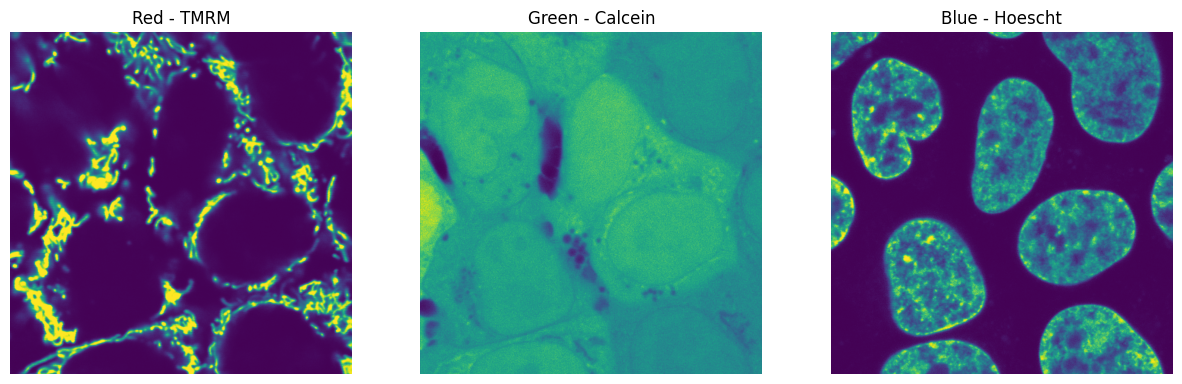

In [1]:
import skimage
import czifile
import numpy as np
import matplotlib.pyplot as plt

# read in an example image with calcein, tmrm, and hoescht
# for nuclei counting, cellpose counting, and mfi 
mass_image_path = r'images\SCR_zstack_01.czi'
mass_image = czifile.imread(mass_image_path)
mass_image = np.squeeze(mass_image)
mass_slice = mass_image[:,3,:,:]

fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].imshow(mass_slice[0])
ax[0].set_title('Red - TMRM')
ax[0].axis('off')
ax[1].imshow(mass_slice[1])
ax[1].set_title('Green - Calcein')
ax[1].axis('off')
ax[2].imshow(mass_slice[2])
ax[2].set_title('Blue - Hoescht')
ax[2].axis('off')
plt.show()



1. Counting the number of nuclei

0.481551606805293


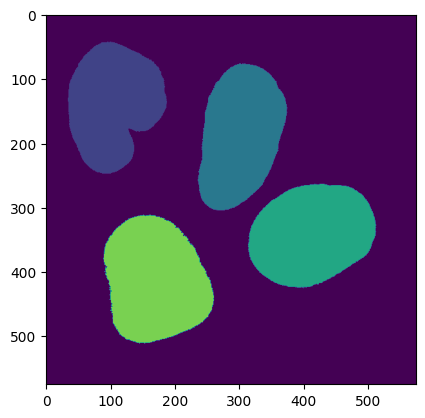

5


In [ ]:
import skimage.morphology

# adjustment and normalization with segmentation
blue_channel = mass_slice[2]
nuclei_threshold = skimage.filters.threshold_otsu(blue_channel)
nuclei = blue_channel > nuclei_threshold
nuclei_mask_filled = skimage.morphology.remove_small_holes(nuclei, area_threshold=5000)
print(np.sum(nuclei_mask_filled) / (mass_slice.shape[1] * mass_slice.shape[2]))

# remove objects touching the edge of the image
nuclei_mask_clean = skimage.segmentation.clear_border(nuclei_mask_filled)
# label images
nuclei_labelled = skimage.measure.label(nuclei_mask_clean)
plt.imshow(nuclei_labelled)
plt.show()
# show the number of labels
num_nuclei = nuclei_labelled.max()
print(num_nuclei)

Optional Cellpose intracellular segmentation (Yiming's Code)

In [ ]:
# import cellpose
from cellpose import models, utils, io
# initialize the model
model = models.Cellpose(gpu=False, model_type='cyto')
green_channel = mass_slice[1] # get the calcein channel
# segment the green channel
cellpose_masks, flows, styles, diams = model.eval(green_channel, diameter=120) # 64 is also good
# show the cell segmentations and number of cells
plt.imshow(cellpose_masks)
plt.show()
print(cellpose_masks.max())


ModuleNotFoundError: No module named 'cellpose'

3. Surface Area

188463


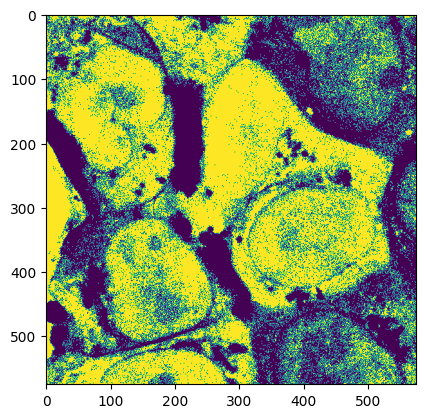

In [ ]:
green_channel = mass_slice[1]
green_channel_adj = skimage.exposure.equalize_adapthist(green_channel)
green_threshold = skimage.filters.threshold_otsu(green_channel_adj)
green_mask = green_channel_adj > green_threshold
# count the number of pixels covered by the mask (sun)
surface_area = np.sum(green_mask)
print(surface_area)
plt.imshow(green_mask)
plt.show()

4. Intersection of two components

(2, 3440, 3440)


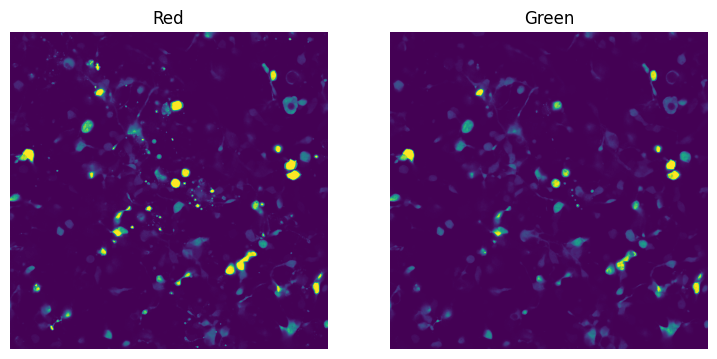

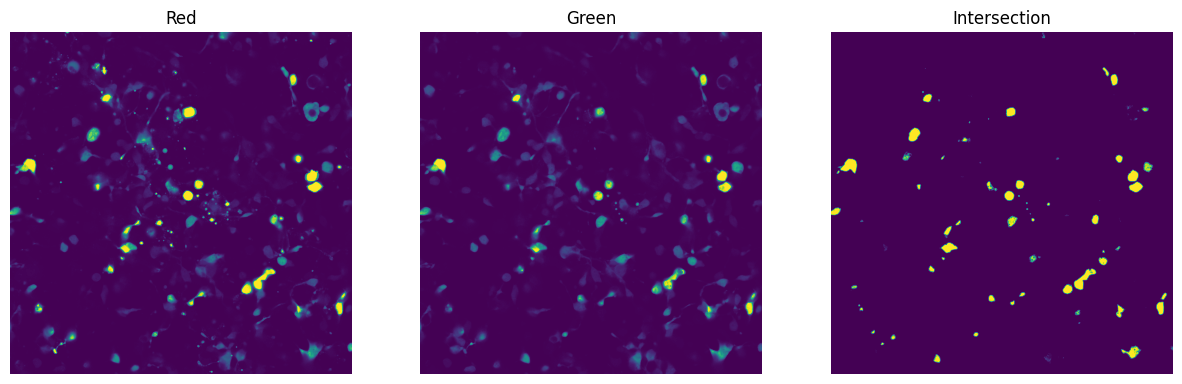

In [ ]:
# read in a propagation file to do intersection
prop_file = r'data/GFP_2A_aSyn_RFP_CHd5_04.czi'
prop_image = czifile.imread(prop_file)
prop_image = np.squeeze(prop_image)

print(prop_image.shape)
# show both channels
fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(prop_image[0])
ax[0].set_title('Red')
ax[0].axis('off')
ax[1].imshow(prop_image[1])
ax[1].set_title('Green')
ax[1].axis('off')
plt.show()
# generate masks for both channels
red_mask = prop_image[0] > skimage.filters.threshold_otsu(prop_image[0])
green_mask = prop_image[1] > skimage.filters.threshold_otsu(prop_image[1])
# take the bitwise intersection of both masks
intersection = red_mask & green_mask
# show both channels and their intersection
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
ax[0].imshow(prop_image[0])
ax[0].set_title('Red')
ax[0].axis('off')
ax[1].imshow(prop_image[1])
ax[1].set_title('Green')
ax[1].axis('off')
ax[2].imshow(intersection)
ax[2].set_title('Intersection')
ax[2].axis('off')
plt.show()

5. Mean Fluorescence Intensity (MFI)

48311.543228018614


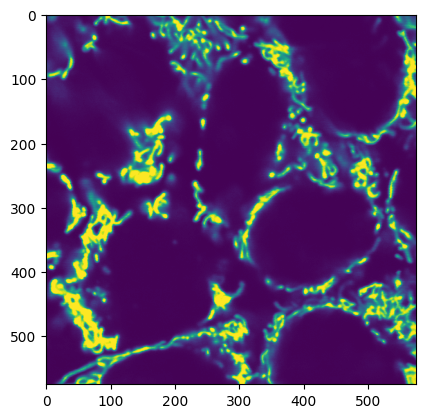

In [ ]:
# use red channel (tmrm) from mass image
red_channel = mass_slice[0]
# threshold
red_threshold = skimage.filters.threshold_otsu(red_channel)
red_mask = red_channel > red_threshold
# compute the value of each raw masked pixel
mfi = np.mean(red_channel[red_mask > 0])

print(mfi)
plt.imshow(red_channel)
plt.show()

6. Shape Measurements

0.7914926785923148
0.18216413173647425


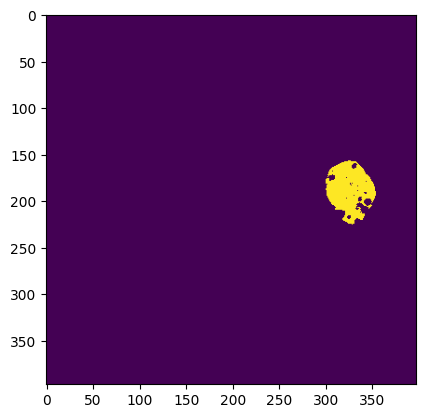

In [2]:
import skimage.measure

shape_image_path = r'images/OA_Inclusion_12.czi'
shape_image = czifile.imread(shape_image_path)
shape_image = np.squeeze(shape_image)
# contrast adjustment and thresholding
shape_image = shape_image[1]
shape_image = skimage.exposure.adjust_sigmoid(shape_image)
shape_mask = shape_image > skimage.filters.threshold_otsu(shape_image)
shape_label = skimage.measure.label(shape_mask)

props = skimage.measure.regionprops(shape_label)

# 1. Elongation (axis major length / axis minor length)  
elongation = props[0].axis_minor_length / props[0].axis_major_length
print(elongation)
# 2. Circularity
circularity = 4 * np.pi * (props[0].area / props[0].perimeter**2)
print(circularity)

plt.imshow(shape_label)
plt.show()
